# Analisis of Assortativity bottleneck and plotting spectral CTE vs Learned CTE

In [1]:
import torch
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader
from datasets.SBM_dataset import SBM_pyg
from transforms import FeatureDegree
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


from torch.nn import Linear
from torch_geometric.nn import DenseGraphConv
from torch_geometric.utils import to_dense_batch, to_dense_adj

from layers.CT_layer import dense_CT_rewiring
from layers.MinCut_Layer import dense_mincut_pool
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.linalg import fractional_matrix_power
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import networkx as nx

from sklearn.manifold import TSNE

from torch_geometric.utils import to_networkx

import pandas as pd
from tqdm import tqdm

C:\Users\adria\miniconda3\envs\pygeom\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read graph and prepare architecture

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [74]:
dataset_name = "COLLAB"

In [75]:
dataset = TUDataset(root='data/colab/TUDataset',name=dataset_name, pre_transform=FeatureDegree(), use_node_attr=True)
BATCH_SIZE = 2

if dataset_name == "COLLAB":
    num_of_centers = 75
    model_to_import = "trained_models/CTNet/COLLAB_CTNet_17_05_22__08_56_iter0.pth"

elif dataset_name == "REDDIT-BINARY":
    num_of_centers = 420 #75 collab, 420 reddit, 20 imdb, 17 MUTAG, 200 SBM
    model_to_import = "trained_models/CTNet/REDDIT-BINARY_CTNet_17_05_22__08_50_iter0.pth"
    
len(dataset)

5000

In [76]:
idx = list(range(len(dataset.data.y)))
train_indices, test_indices = train_test_split(idx, test_size=0.2, stratify=dataset.data.y,
                                random_state=12345, shuffle=True)

In [77]:
train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_dataset), len(test_dataset)

(4000, 1000)

In [78]:
new_order = train_indices + test_indices
dataset_ordered = dataset[new_order]
full_loader =  DataLoader(dataset_ordered, batch_size=BATCH_SIZE, shuffle=False)
len(dataset_ordered)

5000

In [79]:
# Test loader 2
dataset_test = dataset[test_indices]
test_loader_2 =  DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=False)
len(dataset_test)

1000

In [80]:
class CTNet_toy(torch.nn.Module):
    def __init__(self, in_channels, out_channels, k_centers, hidden_channels=32, EPS=1e-15):
        super(CTNet_toy, self).__init__()
        self.EPS=EPS
        # GCN Layer - MLP - Dense GCN Layer
        #self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv1 = DenseGraphConv(hidden_channels, hidden_channels)
        self.conv2 = DenseGraphConv(hidden_channels, hidden_channels)
        
        # The degree of the node belonging to any of the centers
        num_of_centers1 =  k_centers # k1 #order of number of nodes
        self.pool1 = Linear(hidden_channels, num_of_centers1)
        num_of_centers2 =  16 # k2 #mincut 
        self.pool2 = Linear(hidden_channels, num_of_centers2) 

        # MLPs towards out 
        self.lin1 = Linear(in_channels, hidden_channels)
        self.lin2 = Linear(hidden_channels, hidden_channels)
        self.lin3 = Linear(hidden_channels, out_channels)
        self.ct_embendding = None
        self.new_adj = torch.zeros(0)
        self.new_nodes = torch.zeros(0)
        self.new_mincut = torch.zeros(0)
        
    def forward(self, x, edge_index, batch):    # x torch.Size([N, N]),  data.batch  torch.Size([661])  
        # Make all adjacencies of size NxN 
        adj = to_dense_adj(edge_index, batch)   # adj torch.Size(B, N, N])
 
        x, mask = to_dense_batch(x, batch)      # x torch.Size([20, N, 32]) ; mask torch.Size([20, N]) batch_size=20

        x = self.lin1(x)
        # First mincut pool for computing Fiedler adn rewire 
        s1  = self.pool1(x)
        
        self.ct_embedding = s1.clone().detach()

        if torch.isnan(adj).any():
            print("adj nan")
        if torch.isnan(x).any():
            print("x nan")
        
        # CT REWIRING
        adj, CT_loss, ortho_loss1 = dense_CT_rewiring(x, adj, s1, mask, EPS = self.EPS) # out: x torch.Size([20, N, F'=32]),  adj torch.Size([20, N, N])
        self.new_adj = adj.clone()


        # CONV1: Now on x and rewired adj: 
        x = self.conv1(x, adj) #out: x torch.Size([20, N, F'=32])
        
        # MLP of k=16 outputs s
        s2 = self.pool2(x) # s torch.Size([20, N, k])
        
        # MINCUT_POOL
        # Call to dense_cut_mincut_pool to get coarsened x, adj and the losses: k=16
        x, adj, mincut_loss2, ortho_loss2 = dense_mincut_pool(x, adj, s2, mask, EPS=self.EPS) # out x torch.Size([20, k=16, F'=32]),  adj torch.Size([20, k2=16, k2=16])
        self.new_nodes = x.clone()
        self.new_mincut = adj.clone()
        
        # CONV2: Now on coarsened x and adj: 
        x = self.conv2(x, adj) #out x torch.Size([20, 16, 32])
        
        # Readout for each of the 20 graphs
        x = x.sum(dim=1) # x torch.Size([20, 32])
        
        # Final MLP for graph classification: hidden channels = 32
        x = F.relu(self.lin2(x))
        x = self.lin3(x) 
        CT_loss = CT_loss + ortho_loss1
        mincut_loss = mincut_loss2 + ortho_loss2
        #print("x", x)
        return F.log_softmax(x, dim=-1), CT_loss, mincut_loss

In [81]:
model =  CTNet_toy(dataset.num_features, dataset.num_classes,num_of_centers).to(device)
model.load_state_dict(torch.load(model_to_import, map_location=torch.device(device)))
model.eval()

CTNet_toy(
  (conv1): DenseGraphConv(32, 32)
  (conv2): DenseGraphConv(32, 32)
  (pool1): Linear(in_features=32, out_features=75, bias=True)
  (pool2): Linear(in_features=32, out_features=16, bias=True)
  (lin1): Linear(in_features=1, out_features=32, bias=True)
  (lin2): Linear(in_features=32, out_features=32, bias=True)
  (lin3): Linear(in_features=32, out_features=3, bias=True)
)

In [82]:
@torch.no_grad()
def test(loader):
    model.eval()
    correct = 0
    for data in loader:
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        #print(next(model.parameters()).device)
        #print(data.x.device)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()

    return loss, correct / len(loader.dataset)

In [83]:
loss, acc = test(test_loader)
print(loss, acc)

tensor(12.9589, device='cuda:0') 0.722


In [84]:
loss, acc = test(train_loader)
print(loss, acc)

tensor(13.5817, device='cuda:0') 0.69875


In [85]:
loss, acc = test(full_loader)
print(loss, acc)

tensor(12.9589, device='cuda:0') 0.7034


## Calculate Prediction - Assortativity - Bottleneck

In [86]:
def test_and_stats(loader):
    label_list = []
    label_pred_list = []
    bottleneck_list = []
    assortativity_list = []
    model.eval()
    correct = 0
    for data in tqdm(loader):
        data = data.to(device)
        pred, mc_loss, o_loss = model(data.x, data.edge_index, data.batch)
        #print(next(model.parameters()).device)
        #print(data.x.device)
        loss = F.nll_loss(pred, data.y.view(-1)) + mc_loss + o_loss
        correct += pred.max(dim=1)[1].eq(data.y.view(-1)).sum().item()
        
        label_pred_list.extend(pred.max(dim=1)[1])
        label_list.extend(data.y.view(-1))
        
        #G = to_networkx(data, node_attrs=["x"], to_undirected=True)
    
    label_list = [l.detach().cpu().item() for l in label_list]
    label_pred_list = [l.detach().cpu().item() for l in label_pred_list]
    df_data = pd.DataFrame(list(zip(label_list,label_pred_list)), columns=['Y','Yhat'])
    df_data['Correct prediction'] = df_data['Y']==df_data['Yhat']
    return loss, correct / len(loader.dataset), df_data

In [87]:
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [88]:
loss, acc, df_data = test_and_stats(test_loader)
print(loss, acc)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:08<00:00, 113.00it/s]


tensor(9.9579, device='cuda:0', grad_fn=<AddBackward0>) 0.723


In [89]:
stat_test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)
assortativity_ls = []
bottleneck_list = []
for graph in tqdm(stat_test_loader):
    G = to_networkx(graph, node_attrs=["x"], to_undirected=True)
    assortativity_ls.append(nx.degree_assortativity_coefficient(G))
    
    A = nx.adjacency_matrix(G)
    L = nx.normalized_laplacian_matrix(G)
    # Finding eigen values and eigen vectors
    e, evecs = np.linalg.eig(L.todense())
    bottleneck_list.append(sorted(e)[1].real)

  0%|                                                                                                                                                                                    | 0/1000 [00:00<?, ?it/s]C:\Users\adria\AppData\Local\Temp\ipykernel_11948\2514097341.py:8: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
C:\Users\adria\miniconda3\envs\pygeom\lib\site-packages\networkx\algorithms\assortativity\correlation.py:298: RuntimeWarning: invalid value encountered in double_scalars
  return (xy * (M - ab)).sum() / np.sqrt(vara * varb)
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:35<00

In [90]:
df_data['assortativity'] = assortativity_ls
df_data['assortativity'].fillna(1., inplace=True)
df_data['bottleneck'] = bottleneck_list

In [91]:
df_data['Y'] = df_data['Y'].astype("category")
df_data['Yhat'] = df_data['Yhat'].astype("category")
df_data['Correct prediction'] = df_data['Correct prediction'].astype("bool")
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Y                   1000 non-null   category
 1   Yhat                1000 non-null   category
 2   Correct prediction  1000 non-null   bool    
 3   assortativity       1000 non-null   float64 
 4   bottleneck          1000 non-null   float64 
dtypes: bool(1), category(2), float64(2)
memory usage: 18.9 KB


In [92]:
df_data.sample(5)

,Y,Yhat,Correct prediction,assortativity,bottleneck
898,0,2,False,-0.035043,0.071468
473,2,0,False,0.390951,0.462885
531,0,2,False,1.000000,1.021739
512,0,0,True,-0.150838,0.053902
558,0,0,True,0.009226,0.312766


**Percentage for each class**

In [93]:
df_data['Y'].value_counts(), df_data['Yhat'].value_counts()

(0    520
 2    325
 1    155
 Name: Y, dtype: int64,
 0    516
 2    294
 1    190
 Name: Yhat, dtype: int64)

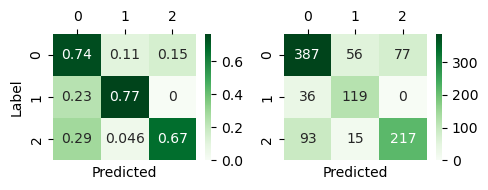

In [94]:

fig = plt.figure(figsize=(5,2))

ax1 = plt.subplot2grid((1, 2), (0, 0))
ax2 = plt.subplot2grid((1, 2), (0, 1))

conf_mat = confusion_matrix(df_data['Y'],df_data['Yhat'], normalize='true')
sns.heatmap(conf_mat, annot=True, cmap='Greens', ax=ax1)
ax1.xaxis.tick_top()
ax1.set_ylabel('Label')
ax1.set_xlabel('Predicted')

conf_mat = confusion_matrix(df_data['Y'],df_data['Yhat'])
sns.heatmap(conf_mat, annot=True, cmap='Greens', ax=ax2,  fmt='g')
ax2.xaxis.tick_top()
plt.tight_layout()
ax2.set_xlabel('Predicted')

plt.show()

**Correlation Assortativity with Label and Prediction**

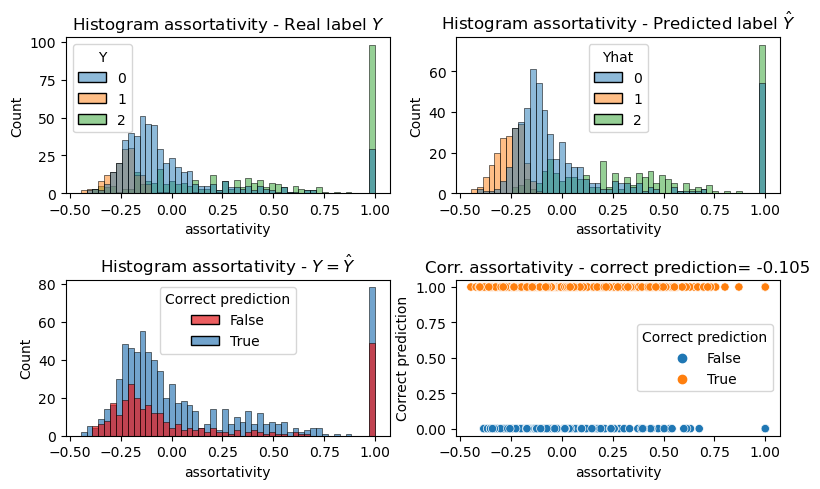

In [95]:
fig = plt.figure(figsize=(8,5))

ax1 = plt.subplot2grid((2,2), (0, 0))
ax2 = plt.subplot2grid((2,2), (0, 1))
ax3 = plt.subplot2grid((2,2), (1, 0), rowspan=2)
ax4 = plt.subplot2grid((2,2), (1, 1))

sns.histplot(data=df_data, x='assortativity', hue='Y', alpha=0.5, ax=ax1, palette='tab10',bins=50)
sns.histplot(data=df_data, x='assortativity', hue='Yhat', alpha=0.5, ax=ax2, palette='tab10',bins=50)
sns.histplot(data=df_data, x='assortativity', hue='Correct prediction', alpha=0.7, ax=ax3, palette='Set1',bins=50)
sns.scatterplot(data=df_data, x='assortativity', y='Correct prediction', hue='Correct prediction', ax=ax4)

ax1.set_title("Histogram assortativity - Real label $Y$")
ax2.set_title("Histogram assortativity - Predicted label $\hat{Y}$")
ax3.set_title("Histogram assortativity - $Y=\hat{Y}$")
ax4.set_title(f"""Corr. assortativity - correct prediction= {df_data.corr()['bottleneck']['Correct prediction']:.3f}""")
plt.tight_layout()
plt.show()

**Correlation Bottleneck with Label and Prediction**

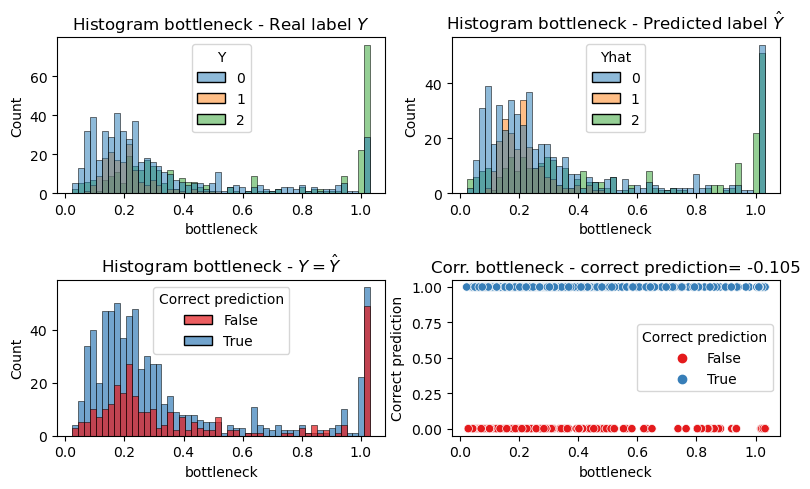

In [96]:
fig = plt.figure(figsize=(8,5))

ax1 = plt.subplot2grid((2,2), (0, 0))
ax2 = plt.subplot2grid((2,2), (0, 1))
ax3 = plt.subplot2grid((2,2), (1, 0))
ax4 = plt.subplot2grid((2,2), (1, 1))

sns.histplot(data=df_data, x='bottleneck', hue='Y', alpha=0.5, ax=ax1, palette='tab10',bins=50)
sns.histplot(data=df_data, x='bottleneck', hue='Yhat', alpha=0.5, ax=ax2, palette='tab10',bins=50)
sns.histplot(data=df_data, x='bottleneck', hue='Correct prediction', alpha=0.7, ax=ax3, palette='Set1',bins=50)
sns.scatterplot(data=df_data, x='bottleneck', y='Correct prediction', hue='Correct prediction', ax=ax4, palette='Set1')

ax1.set_title("Histogram bottleneck - Real label $Y$")
ax2.set_title("Histogram bottleneck - Predicted label $\hat{Y}$")
ax3.set_title("Histogram bottleneck - $Y=\hat{Y}$")
ax4.set_title(f"""Corr. bottleneck - correct prediction= {df_data.corr()['bottleneck']['Correct prediction']:.3f}""")

plt.tight_layout()
plt.show()

**Correlation Assortativity with bottleneck**

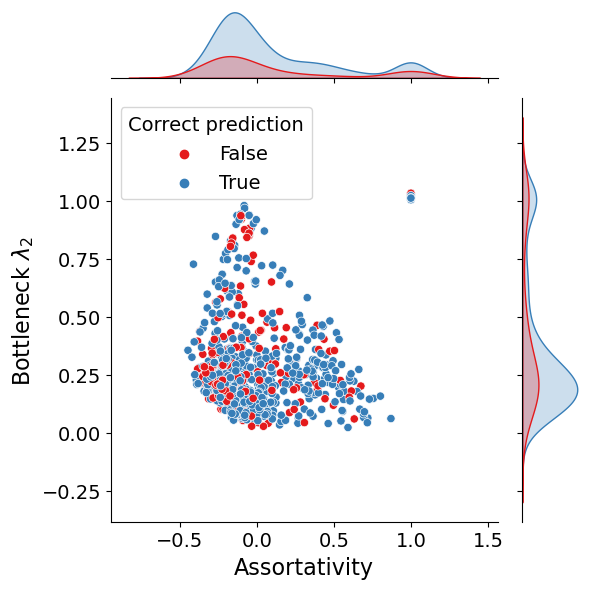

In [97]:
ax= sns.jointplot(data=df_data, x='assortativity', y='bottleneck', hue='Correct prediction', palette='Set1')
plt.legend(title='Correct prediction', fontsize='14', title_fontsize='14')
plt.tick_params(axis='both', which='major', labelsize=14)
plt.xlabel('Assortativity', fontsize=16)
plt.ylabel('Bottleneck $\lambda_2$', fontsize=16)
plt.tight_layout()
plt.savefig(f"figs\AssortativeBottleneckAccuracy\ScatterAsssortBottle{dataset_name}.pdf")
plt.show()

In [98]:
df_data_fig = df_data.rename(columns={'Y':'Label', 'Yhat':'Predicted'})

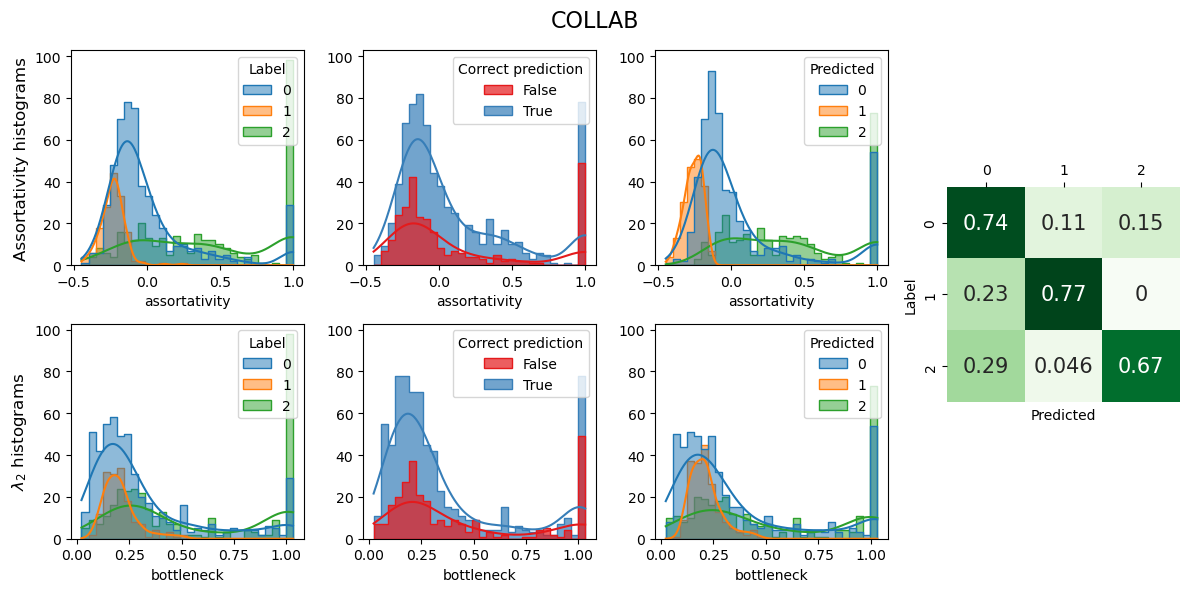

In [99]:
fig = plt.figure(figsize=(12,6))

ax11 = plt.subplot2grid((4,8), (0, 0), rowspan=2, colspan=2)
ax12 = plt.subplot2grid((4,8), (0, 2), sharey=ax11, rowspan=2, colspan=2)
ax13 = plt.subplot2grid((4,8), (0, 4), sharey=ax11, rowspan=2, colspan=2)
ax21 = plt.subplot2grid((4,8), (2, 0), rowspan=2, colspan=2)
ax22 = plt.subplot2grid((4,8), (2, 2), sharey=ax21, rowspan=2, colspan=2)
ax23 = plt.subplot2grid((4,8), (2, 4), sharey=ax21, rowspan=2, colspan=2)
ax14 = plt.subplot2grid((4,8), (1, 6), rowspan=2, colspan=2)

style = {'bins':30, 'kde':True, 'element':"step"}
         

sns.histplot(data=df_data_fig, x='assortativity', hue='Label', 
             alpha=0.5, ax=ax11, palette='tab10', **style)
sns.histplot(data=df_data_fig, x='assortativity', hue='Correct prediction',
             alpha=0.7, ax=ax12, palette='Set1', **style)
ax12.set_ylabel(None)
sns.histplot(data=df_data_fig, x='assortativity', hue='Predicted',
             alpha=0.5, ax=ax13, palette='tab10', **style)
ax13.set_ylabel(None)

sns.histplot(data=df_data_fig, x='bottleneck', hue='Label',
             alpha=0.5, ax=ax21, palette='tab10', **style)
sns.histplot(data=df_data_fig, x='bottleneck', hue='Correct prediction',
             alpha=0.7, ax=ax22, palette='Set1', **style)
ax22.set_ylabel(None)
sns.histplot(data=df_data_fig, x='bottleneck', hue='Predicted',
             alpha=0.5, ax=ax23, palette='tab10', **style)
ax23.set_ylabel(None)

conf_mat = confusion_matrix(df_data['Y'],df_data['Yhat'], normalize='true')
sns.heatmap(conf_mat, annot=True, cmap='Greens', ax=ax14, cbar=False, annot_kws={"fontsize":15})
ax14.xaxis.tick_top()
ax14.set_ylabel('Label')
ax14.set_xlabel('Predicted')


ax11.set_ylabel("Assortativity histograms", fontsize=12)
ax21.set_ylabel("$\lambda_2$ histograms", fontsize=12)

fig.suptitle(f"{dataset_name}", fontsize=16)
plt.tight_layout()

plt.savefig(f"figs\AssortativeBottleneckAccuracy\HistAsssortBottle{dataset_name}.pdf")

plt.show()

## Predict CT Embedd for the graph

In [29]:
loader =  DataLoader(test_dataset[15:], batch_size=1, shuffle=False)
grafo_init= next(iter(loader))
grafo_init.to(device)

DataBatch(edge_index=[2, 600], y=[1], x=[233, 1], num_nodes=233, batch=[233], ptr=[2])

In [30]:
pred, mc_loss, o_loss = model(grafo_init.x, grafo_init.edge_index, grafo_init.batch)
loss = F.nll_loss(pred, grafo_init.y.view(-1)) + mc_loss + o_loss
pred.max(dim=-1)[1].eq(grafo_init.y.view(-1)).sum().item()

1

In [31]:
model.ct_embedding.shape, grafo_init.x.shape, grafo_init

(torch.Size([1, 233, 420]),
 torch.Size([233, 1]),
 DataBatch(edge_index=[2, 600], y=[1], x=[233, 1], num_nodes=233, batch=[233], ptr=[2]))

In [32]:
ct_embedding = torch.tanh(model.ct_embedding).cpu().detach().numpy().squeeze().copy()

### Plot learned CT

In [33]:
def visualize(z, color, size=10, save=False, title='img'):
    plt.figure(figsize=(5,5))
    plt.scatter(z[:, 0], z[:, 1], s=size, c=color, cmap="Set2")
    plt.colorbar()
    plt.xticks([], [])
    plt.yticks([], [])
    if save:
        plt.savefig(title+'.pdf') 
    plt.show()

In [34]:
from sklearn import random_projection
transformer = random_projection.GaussianRandomProjection(n_components=ct_embedding.shape[0], random_state=42)
ct_embedding_JL = transformer.fit_transform(ct_embedding)
ct_embedding.shape, ct_embedding_JL.shape

((233, 420), (233, 233))

In [35]:
ct_e_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=5, early_exaggeration=20,
               random_state=90).fit_transform(ct_embedding_JL) #4242

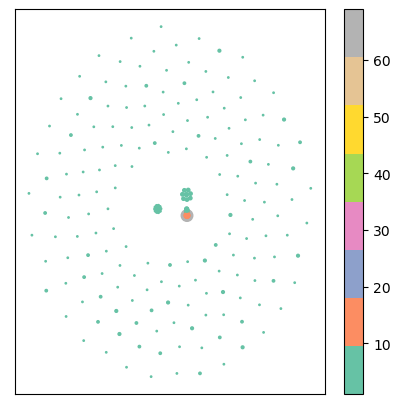

In [36]:
degree = grafo_init.x.cpu().detach().numpy()
visualize(ct_e_2d, color = degree, size= degree)

In [37]:
def graph_vol(G):
    A = nx.adjacency_matrix(G)
    D = A.sum(axis=1)
    D = D.squeeze()
    d = np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        d[i] = D[0,i]
    vol = d.sum()
    return vol

def commute_times_embedding(G,e, evecs):
    n = G.number_of_nodes()
    vol = graph_vol(G)
    A = nx.adjacency_matrix(G)
    D = A.sum(axis=1)
    Phi = evecs
    Lambda = np.diag(e)
    Lambda = fractional_matrix_power(Lambda, -0.5)
    Lambda[0,0] = 0
    CTE = np.sqrt(vol)*np.matmul(Lambda,np.transpose(Phi))
    # Embedding is in the columns
    return CTE

In [38]:
from torch_geometric.utils import to_networkx

G = to_networkx(grafo_init, node_attrs=["x"], to_undirected=True)
nx.is_connected(G), len(list(nx.connected_components(G)))

(False, 3)

In [39]:
A = nx.adjacency_matrix(G)
L = nx.normalized_laplacian_matrix(G)
# Finding eigen values and eigen vectors
e, evecs = np.linalg.eig(L.todense())
# Sort them (both e's and evecs's) ascending
idx =e.argsort()
e = e[idx]
evecs = evecs[:,idx]

e.shape, evecs.shape

C:\Users\adria\AppData\Local\Temp\ipykernel_11948\2076120035.py:1: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
<class 'networkx.utils.decorators.argmap'> compilation 4:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


((233,), (233, 233))

In [40]:
spectral_CTE = commute_times_embedding(G,e, evecs).T

C:\Users\adria\AppData\Local\Temp\ipykernel_11948\2063192752.py:2: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)
C:\Users\adria\AppData\Local\Temp\ipykernel_11948\2063192752.py:14: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


In [41]:
spec_cte_2d = TSNE(n_components=2, learning_rate='auto',
               init='random', perplexity=6, early_exaggeration=100, random_state=200).fit_transform(spectral_CTE.real)

C:\Users\adria\miniconda3\envs\pygeom\lib\site-packages\sklearn\utils\validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


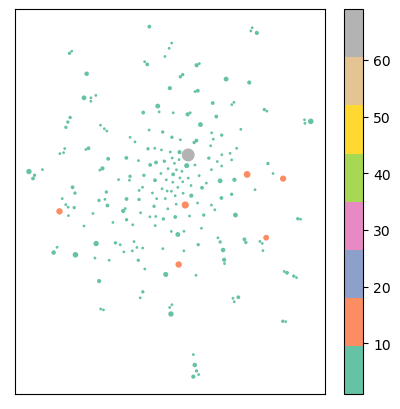

In [42]:
degree = list(dict(G.degree).values())

visualize(spec_cte_2d, color = degree, size= degree, save=True, title='SpectralCTE')

## Comparison

### CT embedding

In [43]:
ct_embedding.shape[0]

233

In [44]:
ct_norms = torch.norm(torch.tensor(ct_embedding_JL),p=2, dim=1)/torch.norm(torch.tensor(ct_embedding_JL),p=2, dim=1).sum()
ct_norms.sum(), ct_norms.shape

(tensor(1.0000), torch.Size([233]))

In [45]:
spectral_CTE.shape

(233, 233)

In [46]:
spec_ct_norms = torch.norm(torch.tensor(spectral_CTE),p=2, dim=1)/torch.norm(torch.tensor(spectral_CTE),p=2, dim=1).sum()

In [47]:
spec_ct_norms.sum(), spec_ct_norms.shape

(tensor(1., dtype=torch.float64), torch.Size([233]))

In [48]:
ct_norms

tensor([0.0048, 0.0046, 0.0040, 0.0040, 0.0040, 0.0040, 0.0048, 0.0040, 0.0040,
        0.0040, 0.0046, 0.0040, 0.0046, 0.0040, 0.0046, 0.0040, 0.0048, 0.0046,
        0.0040, 0.0046, 0.0047, 0.0040, 0.0040, 0.0040, 0.0040, 0.0046, 0.0048,
        0.0048, 0.0047, 0.0040, 0.0047, 0.0046, 0.0046, 0.0040, 0.0047, 0.0047,
        0.0040, 0.0040, 0.0047, 0.0046, 0.0040, 0.0046, 0.0040, 0.0040, 0.0048,
        0.0046, 0.0040, 0.0040, 0.0046, 0.0040, 0.0040, 0.0046, 0.0048, 0.0040,
        0.0047, 0.0040, 0.0046, 0.0040, 0.0040, 0.0040, 0.0048, 0.0046, 0.0047,
        0.0047, 0.0046, 0.0040, 0.0040, 0.0048, 0.0047, 0.0040, 0.0040, 0.0040,
        0.0048, 0.0040, 0.0046, 0.0046, 0.0046, 0.0046, 0.0040, 0.0040, 0.0048,
        0.0040, 0.0040, 0.0040, 0.0046, 0.0040, 0.0040, 0.0048, 0.0040, 0.0040,
        0.0040, 0.0046, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0048, 0.0040,
        0.0040, 0.0047, 0.0040, 0.0040, 0.0040, 0.0040, 0.0040, 0.0047, 0.0046,
        0.0046, 0.0040, 0.0040, 0.0040, 

In [49]:
ct_norms.sum()

tensor(1.0000)

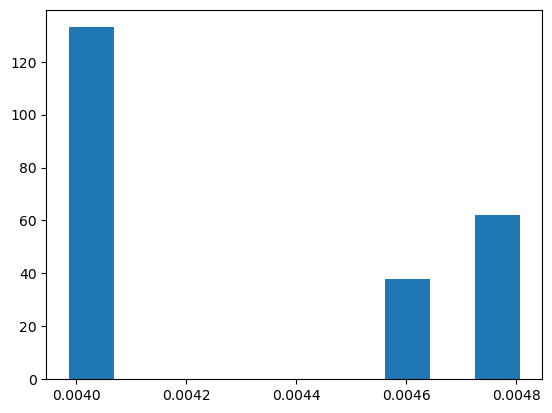

In [50]:
plt.hist(ct_norms.numpy(), bins=10);

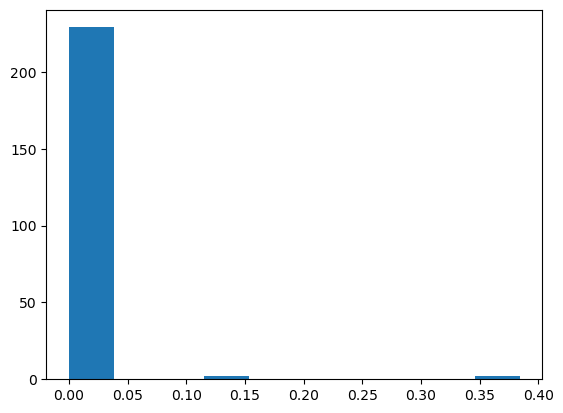

In [51]:
plt.hist(spec_ct_norms.numpy(), bins=10);

In [52]:
from scipy.special import rel_entr

sum(rel_entr(ct_norms, spec_ct_norms)), sum(rel_entr(spec_ct_norms, ct_norms))

(tensor(9.0652, dtype=torch.float64), tensor(4.2893, dtype=torch.float64))

### CT dist KL

In [53]:
CT_dist = torch.cdist(torch.Tensor(ct_embedding_JL),torch.Tensor(torch.Tensor(ct_embedding_JL)))
idx = torch.Tensor(A.todense()).triu().nonzero().T
CT_dist_triu = CT_dist[idx[0], idx[1]]
CT_dist_triu = CT_dist_triu / CT_dist_triu.sum()    
CT_dist_triu.shape, CT_dist_triu.sum()

(torch.Size([300]), tensor(1.))

In [54]:
# get spectral ct dist
spectral_CT_dist = pdist(spectral_CTE.real, 'euclidean')
spectral_CT_dist = torch.Tensor(squareform(spectral_CT_dist))

#get vectorized triu ct dist
idx = torch.Tensor(A.todense()).triu().nonzero().T
spec_CT_dist_triu = spectral_CT_dist[idx[0], idx[1]]
spec_CT_dist_triu = spec_CT_dist_triu / spec_CT_dist_triu.sum()
spec_CT_dist_triu.shape, spec_CT_dist_triu.sum()

(torch.Size([300]), tensor(1.))

In [55]:
from scipy.special import rel_entr

sum(rel_entr(CT_dist_triu, spec_CT_dist_triu)), sum(rel_entr(spec_CT_dist_triu, CT_dist_triu))

(tensor(0.4043), tensor(inf))

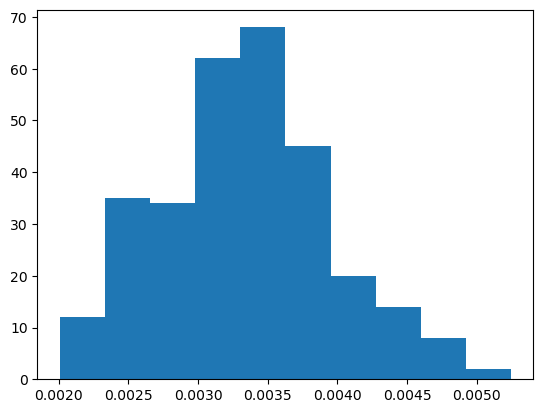

In [56]:
plt.hist(spec_CT_dist_triu.numpy(), bins=10);

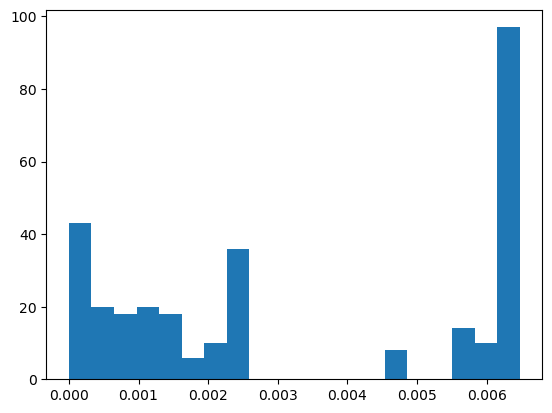

In [57]:
plt.hist(CT_dist_triu.numpy(), bins=20);

## Original


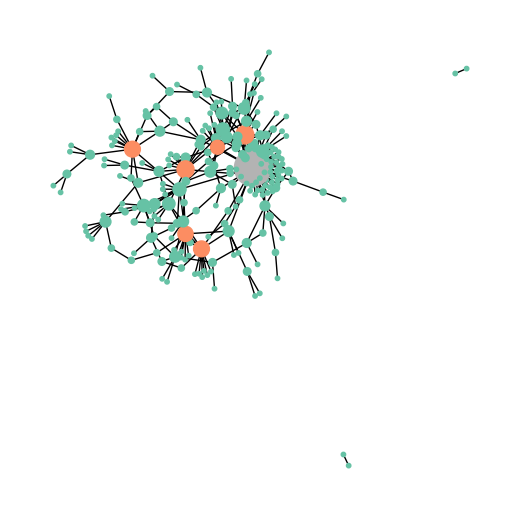

In [58]:
Anx = to_networkx(grafo_init, to_undirected=True)

plt.figure(figsize=(5,5))
pos = nx.spring_layout(Anx, seed=44)
nx.draw(Anx, node_color = list(dict(G.degree).values()), cmap=plt.cm.Set2, pos=pos, node_size=np.array(list(dict(G.degree).values()))*10)
plt.show()

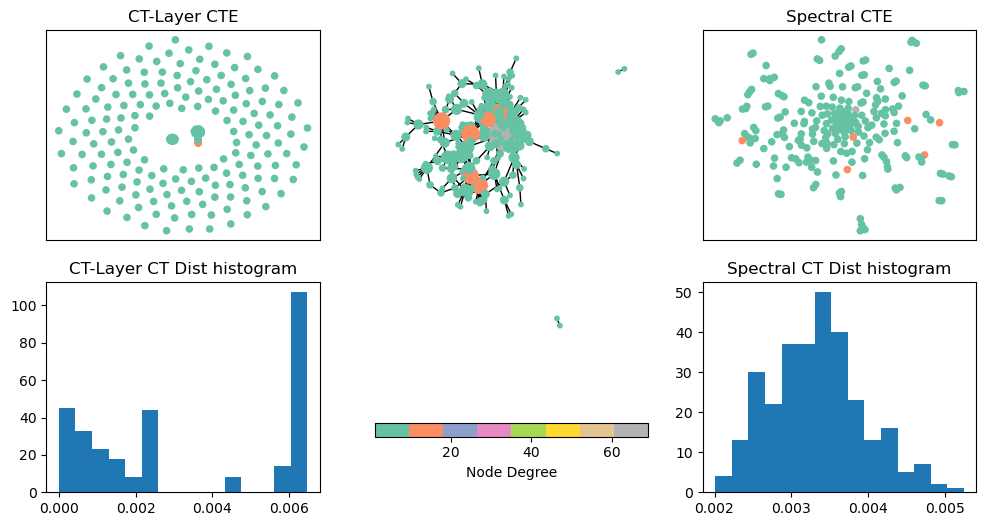

In [59]:

fig = plt.figure(figsize=(12,6))

ax1 = plt.subplot2grid((2, 3), (0, 0))
ax2 = plt.subplot2grid((2, 3), (0, 1), rowspan=2)
ax3 = plt.subplot2grid((2, 3), (0, 2))
ax4 = plt.subplot2grid((2, 3), (1, 0))
ax5 = plt.subplot2grid((2, 3), (1, 2))


ax1.set_xticks([], [])
ax1.set_yticks([], [])
ax1.set_title('CT-Layer CTE')
im1 = ax1.scatter(ct_e_2d[:, 0], ct_e_2d[:, 1], s=20, c=degree, cmap="Set2")


nx.draw(Anx, node_color = list(dict(G.degree).values()), 
        cmap=plt.cm.Set2, pos=pos, node_size=np.array(list(dict(G.degree).values()))*10,
       ax=ax2)
fig.colorbar(im1, orientation='horizontal', ax=ax2, label='Node Degree')


ax3.set_xticks([], [])
ax3.set_yticks([], [])
ax3.set_title('Spectral CTE')
ax3.scatter(spec_cte_2d[:, 0], spec_cte_2d[:, 1], s=20, c=degree, cmap="Set2")


ax4.hist(CT_dist_triu.numpy(), bins=15)
ax4.set_title('CT-Layer CT Dist histogram')



ax5.hist(spec_CT_dist_triu.numpy(), bins=15)
ax5.set_title('Spectral CT Dist histogram')


#plt.savefig('CTEComparison.pdf')
plt.show()